In [87]:
import json
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

import sys
import os 

os.environ["CONFIG_PATHS"] = "../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_10"'
sys.path.append("../src")

from display import Display
from configuration import moves_data

In [28]:
# PATH = "data/2024-11-09_11-10-06-algific"
# PATH = "data/2024-11-09_13-11-13-premotion"
# PATH = "data/2024-11-09_13-11-13-premotion/"
# PATH = "data/2024-11-10_16-28-30-chemotropic"  # With Numpy 1.x
# PATH = "data/2024-11-10_16-38-20-nephratonia"  # With Numpy 2.x
# PATH = "data/2024-11-10_23-09-26-brachyphyllum"  # With 100 rollouts
# PATH = "data/2024-11-11_10-48-13-microsporidia/"  # With 100 rollouts
# PATH = "data/2024-11-11_10-50-19-perchloride/" # with 500 rollouts
# PATH = "data/2024-11-11_11-55-02-turriculate/" # with fast rollouts 20% of the time
# PATH = "data/2024-11-11_12-44-39-cephalopterus/"
# PATH = "data/2024-11-11_13-31-42-gasterolichenes"

# PATH = "data/2024-11-12_00-14-50-anorchism/"
PATH = "data/2024-11-14_00-14-19-funduline"

log_path = f"../{PATH}/logs.txt"

In [29]:
# data/1731122195-monosiphonous - My first long run
# data/2024-11-09_11-10-06-algific - Ran with large cache
# data/2024-11-09_13-11-13-premotion - Ran with no cache

events = []
with open(log_path) as f:
    logs = f.readlines()
    for line in logs:
        # Skip lines that are not events.
        if not line.startswith("event | "):
            continue

        _, timestamp, event, params = line.strip().split(" | ")
        events.append((float(timestamp), event, json.loads(params)))

# Sort events by timestamp.
events.sort(key=lambda x: x[0])

# Adjust timestamps to start at 0.
start_time = events[0][0]
print(f"Start time: {start_time}")

events = [
    (timestamp - start_time, event, params)
    for timestamp, event, params in events
]


Start time: 1731572063.1957262


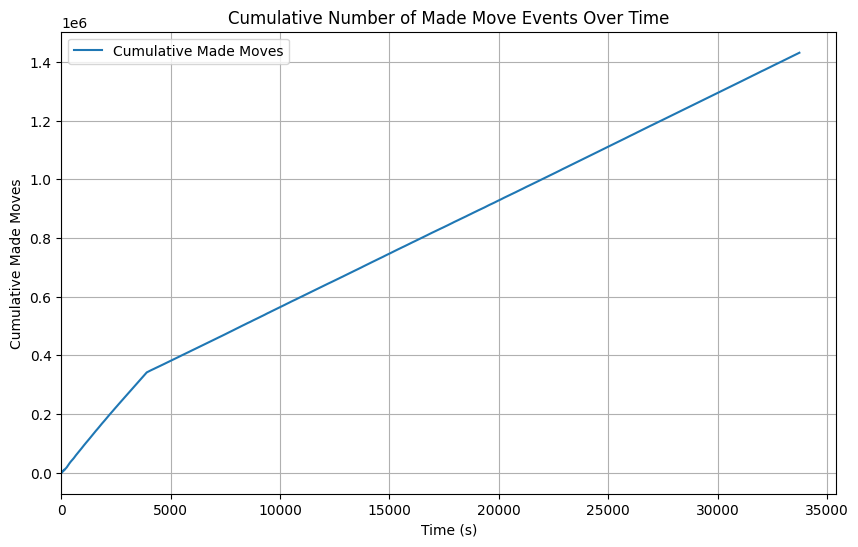

Time to first move: 11.901005744934082


In [30]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
indices = [i for i, event in enumerate(events) if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

print(f"Time to first move: {min(timestamps)}")

In [32]:
print("Number of moves", max(cumulative_made_moves))

Number of moves 1431586


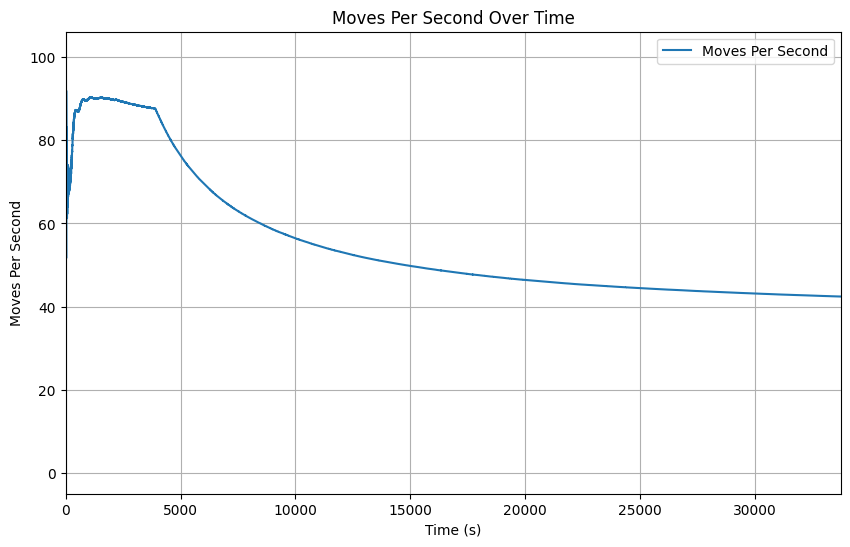

Maximal moves per second during latter half: 50.58680308644466


In [33]:
moves_per_second = []

moves_made = 0
for event in events:
    if event[1] != "made_move":
        continue
    moves_made += 1

    moves_per_second.append(moves_made / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "made_move"], moves_per_second, label='Moves Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Moves Per Second')
plt.title('Moves Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

final_moves_per_sec = max(
    moves_per_second[len(moves_per_second) // 2:]
)
print("Maximal moves per second during latter half:", final_moves_per_sec)

In [34]:
total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

# GPU bottleneck. Closer to 1 means that the GPU is the bottleneck because the
# moves per second we actually got is close to the theoretical maximum based on
# GPU evaluation speed.
# 
# This won't work when using caching.
print("speed relative to if GPU was fully utilized:", final_moves_per_sec / ((total_evaluated / total_duration) / (500 * 0.2 + 100 * 0.8)))

speed relative to if GPU was fully utilized: 1.4741868863068195


In [35]:
# What percent of time is the GPU thread being used?

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.9319941478652403


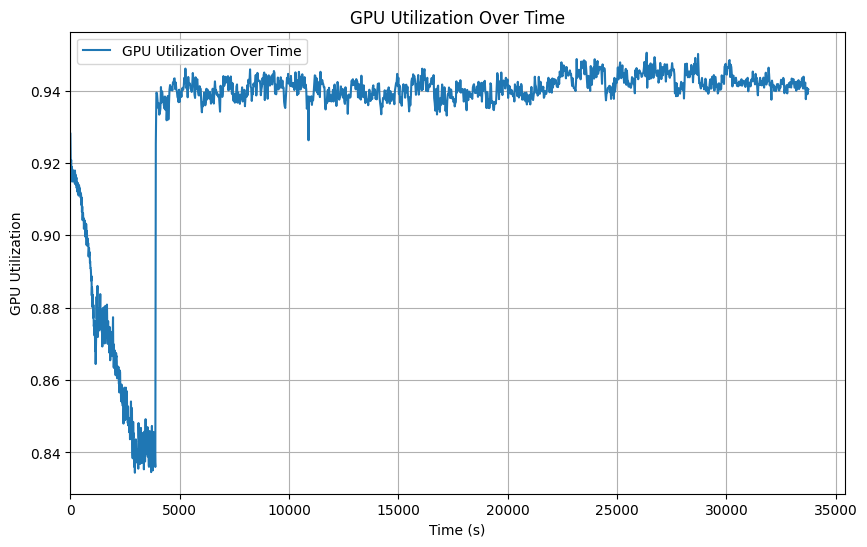

In [36]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

gpu_utilization = []
times = []

window_size = 1000

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    time_interval = evaluations_in_window[-1][0] - evaluations_in_window[0][0]
    duration = sum(event[2]["duration"] for event in evaluations_in_window)

    gpu_utilization.append(duration / time_interval)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.plot(times, gpu_utilization, label='GPU Utilization Over Time')
plt.xlabel('Time (s)')
plt.ylabel('GPU Utilization')
plt.title('GPU Utilization Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()


/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_68975/532304626.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


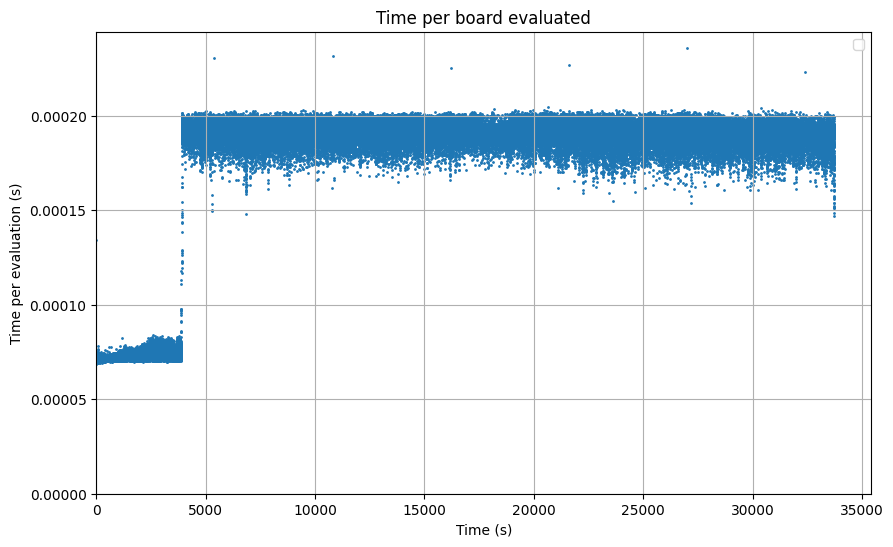

In [37]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

time_per_evaluation = []
times = []

window_size = 10

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    total_evaluations = sum(event[2]["batch_size"] for event in evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per board evaluated')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


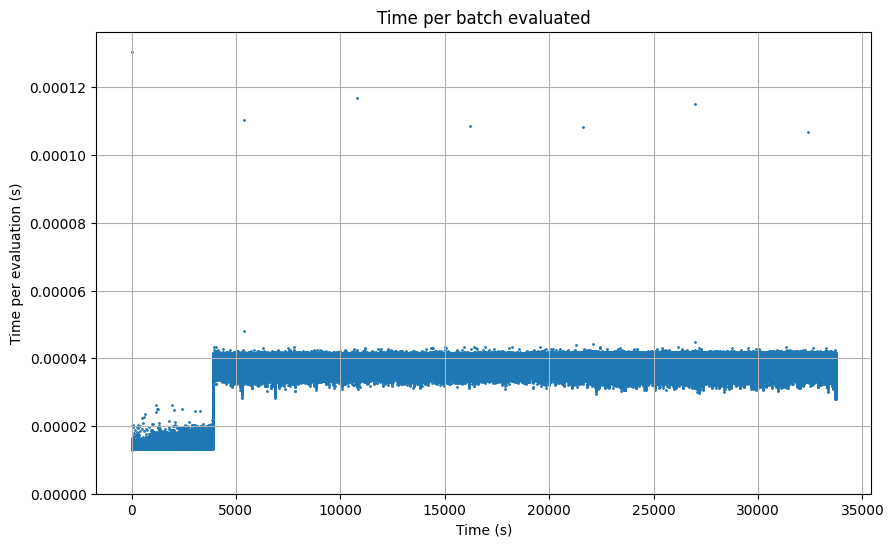

In [38]:
evaluations = [
    event for event in events if (
        event[1] == "gpu_evaluation"
        # and event[0] > 39650
        # and event[0] < 38125
    )
]

time_per_evaluation = []
times = []

window_size = 1

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    number_of_evaluations = len(evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per batch evaluated')
plt.grid(True)
# plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


In [39]:
# What is the average batch size?

batch_sizes = [event[2]["batch_size"] for event in events if event[1] == "gpu_evaluation"]
sum(batch_sizes) / len(batch_sizes)

128.0

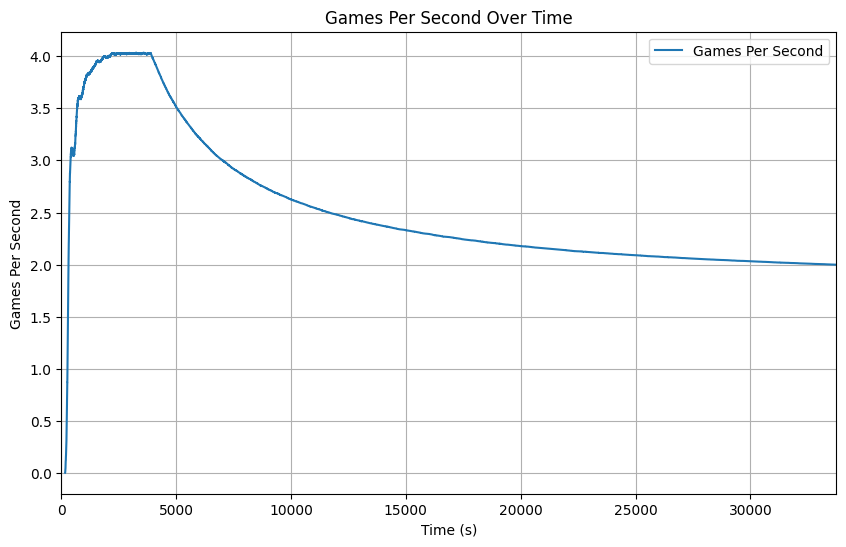

In [40]:
games_per_second = []

games_finished = 0
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1

    games_per_second.append(games_finished / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_per_second, label='Games Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Games Per Second')
plt.title('Games Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

Slope: 1.8671837029227838
Intercept: 5886.04541541775
R-squared: 0.9910685315983909


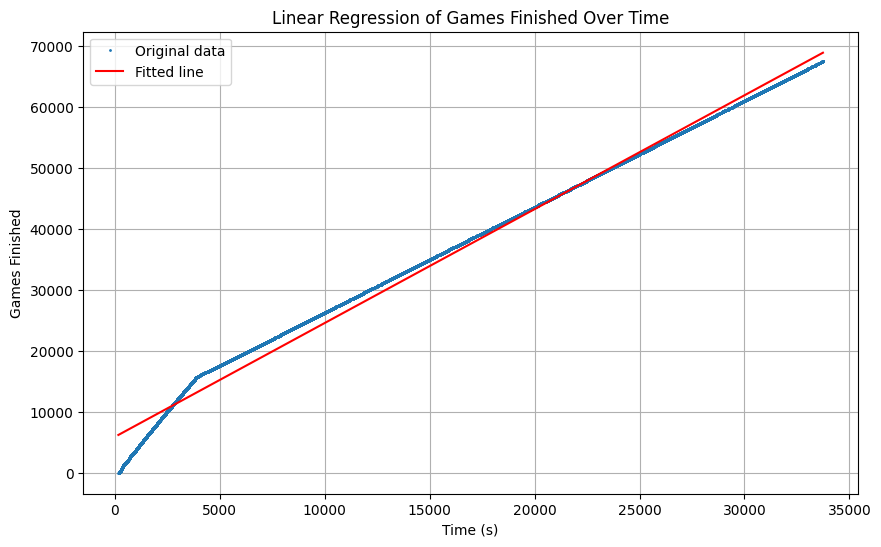

In [44]:
# Prepare the data for linear regression
x = [event[0] for event in events if event[1] == "game_end"]
y = range(len(x))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x, [slope * xi + intercept for xi in x], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Games Finished')
plt.title('Linear Regression of Games Finished Over Time')
plt.legend()
plt.grid(True)
plt.show()

Slope: 87.12414046457295
Intercept: 296038.1002090215
R-squared: 0.9904644858514947


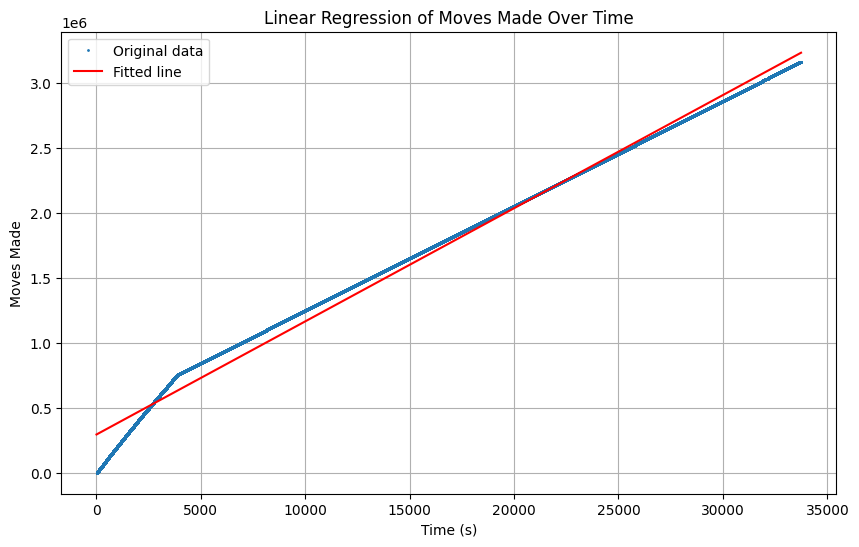

In [43]:

# Prepare the data for linear regression
x_made_move = [event[0] for event in events if event[1] == "made_move"]
y_made_move = [i for i, event in enumerate(events) if event[1] == "made_move"]

# Perform linear regression
slope_made_move, intercept_made_move, r_value_made_move, p_value_made_move, std_err_made_move = scipy.stats.linregress(x_made_move, y_made_move)

# Print the results
print(f"Slope: {slope_made_move}")
print(f"Intercept: {intercept_made_move}")
print(f"R-squared: {r_value_made_move**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x_made_move, y_made_move, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x_made_move, [slope_made_move * xi + intercept_made_move for xi in x_made_move], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Moves Made')
plt.title('Linear Regression of Moves Made Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
game_results = [event[2] for event in events if event[1] == "game_result"]

num_points = {}
for game_result in game_results:
    for key, value in game_result:
        num_points[key] = num_points.get(key, 0) + value

num_points

{'default': 67490.00000000146}

In [47]:
mcts_reports = [event[2] for event in events if event[1] == "mcts_report"]

500


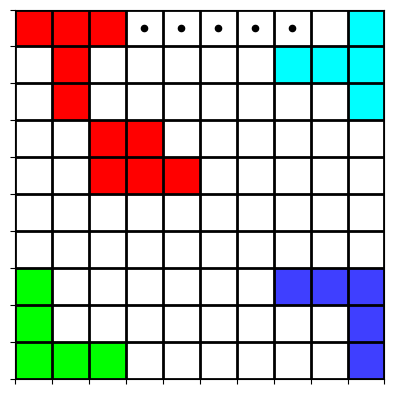

In [90]:
report = mcts_reports[89]

board = np.array(report["board"])
children_visit_counts = report["children_visit_counts"]
children_value_sums = report["children_value_sums"]
children_priors = report["children_priors"]
values = report["values"]

print(sum(children_visit_counts))

Display(board, moves_data()["new_occupieds"][70]).show()

<BarContainer object of 184 artists>

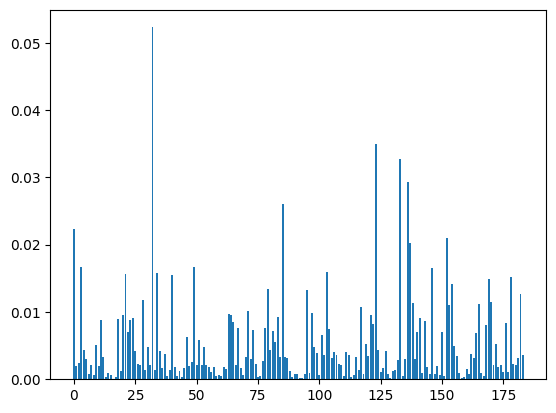

In [79]:
plt.bar(range(len(children_priors)), children_priors)

<BarContainer object of 184 artists>

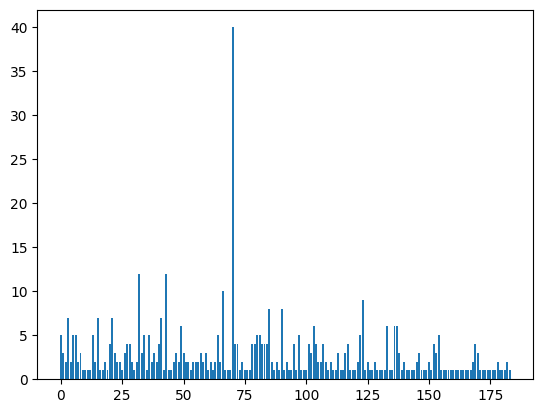

In [80]:
plt.bar(range(len(children_visit_counts)), children_visit_counts)

In [98]:
values

[0.45170801877975464,
 0.3062465786933899,
 0.10273277759552002,
 0.13931265473365784]

<BarContainer object of 184 artists>

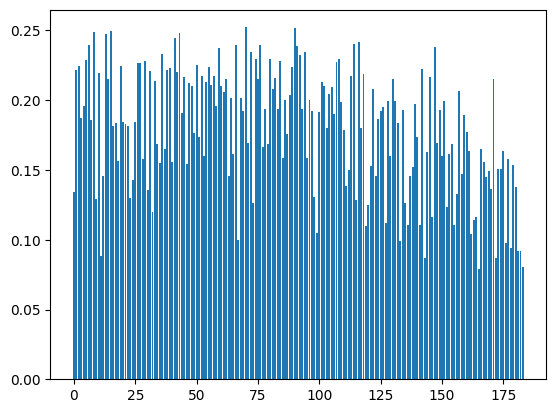

In [100]:
data = np.array(children_value_sums[1]) / np.array(children_visit_counts)
plt.bar(range(len(data)), data)

In [71]:
sum()

100

In [92]:
values[1]

0.3062465786933899